In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/U_net"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Challenge  IMA205.ipynb  j.h5  U_net01	U_net01pbinputtraining.ipynb


In [5]:
%cd "/content/gdrive/My Drive/U_net/Challenge"

/content/gdrive/My Drive/U_net/Challenge


In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import keras
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, MaxPooling2D,Conv2D
from keras.applications import VGG16


In [10]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

Found 627 images belonging to 2 classes.
Found 73 images belonging to 2 classes.


In [14]:
vgg16_model = VGG16(weights='imagenet')

'''Rebuild the vgg16 using an empty sequential model'''
model = Sequential()
layers = [layer for layer in vgg16_model.layers]
i = 0 
for layer in range(len (vgg16_model.layers) - 8):
    model.add(layers[i])
    i+=1

'''Freeze other pre-trained weights'''
for layer in model.layers:
    layer.trainable = False

'''Add the modified final layer'''
model.add(Conv2D(32, (3, 3), input_shape=(14, 14, 512)))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.add(Activation('relu'))


    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

'''Since the problem is binary, I got rid of the output layer and added a more appropriate output layer.'''
model.layers.pop()
model.layers.pop()
model.layers.pop()

'''Freeze other pre-trained weights'''
for layer in model.layers:
    layer.trainable = False

'''Add the modified final layer'''
model.add(Dense(2, activation = 'softmax'))

In [0]:
from keras import optimizers
learning_rate = 0.1
decay_rate = learning_rate / 10
momentum = 0.8
sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(loss='binary_crossentropy',
              optimizer=sgd,
               metrics=['accuracy'])

In [16]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=750 // batch_size,
        epochs=12,
        validation_data=validation_generator,
        validation_steps=70 // batch_size)

model.save_weights('VGG16_freezed_param.h5')

Epoch 1/12
46/46 [==============================] - 520s 11s/step - loss: 6.4028 - acc: 0.5919 - val_loss: 7.0693 - val_acc: 0.5614
Epoch 2/12
46/46 [==============================] - 493s 11s/step - loss: 6.5557 - acc: 0.5933 - val_loss: 6.7866 - val_acc: 0.5789
Epoch 3/12
46/46 [==============================] - 488s 11s/step - loss: 6.1561 - acc: 0.6181 - val_loss: 5.9382 - val_acc: 0.6316
Epoch 4/12
46/46 [==============================] - 487s 11s/step - loss: 6.5391 - acc: 0.5943 - val_loss: 6.7866 - val_acc: 0.5789
Epoch 5/12
46/46 [==============================] - 486s 11s/step - loss: 6.5197 - acc: 0.5955 - val_loss: 6.2961 - val_acc: 0.6094
Epoch 6/12
46/46 [==============================] - 490s 11s/step - loss: 6.3314 - acc: 0.6072 - val_loss: 5.9382 - val_acc: 0.6316
Epoch 7/12
46/46 [==============================] - 490s 11s/step - loss: 6.5776 - acc: 0.5919 - val_loss: 8.2004 - val_acc: 0.4912
Epoch 8/12
46/46 [==============================] - 490s 11s/step - loss: 6.

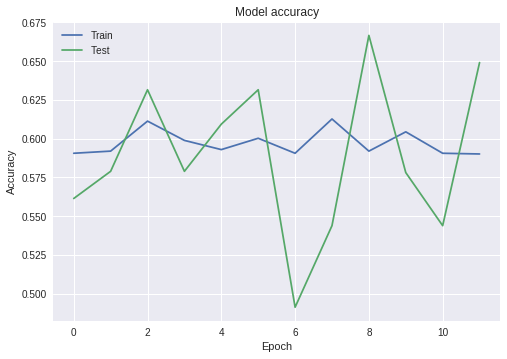

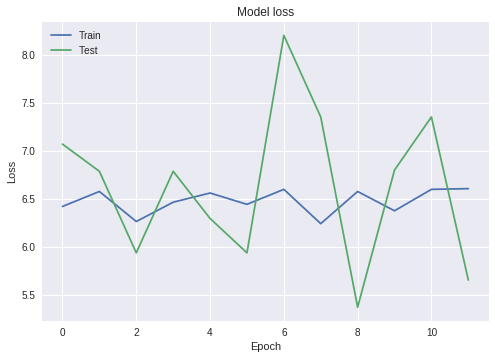

In [17]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
